In [1]:
from __future__ import print_function
import hashlib
import os
import sys
import pickle
from urllib.request import urlretrieve

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile
from IPython.display import display, Image
from PIL import Image
from numpy import random
import pylab as plt
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
from scipy import ndimage
import random
from numpy import genfromtxt

%matplotlib inline

print(tf.__version__)

print('All modules imported.')

1.0.0
All modules imported.


In [17]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [18]:
#mnist.train.images.shape
print(mnist.train.images.shape)
print(mnist.test.images.shape)
print(mnist.validation.images.shape)

(55000, 784)
(10000, 784)
(5000, 784)


In [19]:
train_data_raw = mnist.train.images # Original format of the imported images
train_labels_raw = mnist.train.labels # Original format of the imported labels
validation_data_raw = mnist.validation.images # Original format of the imported images
validation_labels_raw = mnist.validation.labels # Original format of the imported labels
test_data_raw = mnist.test.images # Original format of the imported images
test_labels_raw = mnist.test.labels # Original format of the imported labels

In [20]:
train_data_conv=train_data_raw.reshape(train_data_raw.shape[0],28,28)
validation_data_conv=validation_data_raw.reshape(validation_data_raw.shape[0],28,28)
test_data_conv=test_data_raw.reshape(test_data_raw.shape[0],28,28)

In [21]:
def image_resize(in_arr,image_height,image_width):
        im = Image.fromarray(in_arr)
        new_img =im.resize((image_height,image_width),Image.BILINEAR)
        greyscale_map = list(new_img.getdata())
        greyscale_map = np.array(greyscale_map)
        greyscale_map = greyscale_map.reshape((image_height,image_width))
        return greyscale_map

In [22]:
image_height = 32
image_width = 32

def Image_Concat(X,y,dataset_size):
    dataset = np.ndarray(shape=(dataset_size, image_height, image_width),
                         dtype=np.float32)

    data_labels = []

    i = 0
    w = 0
    while i < dataset_size:     
                
        x_5 = [X[w],X[w+1],X[w+2],X[w+3],X[w+4]]
        y_5 = [y[w],y[w+1],y[w+2],y[w+3],y[w+4]]    
        empty_size = random.randint(1,4)
        # random set0-4 value to 0
        j=empty_size
        
        while j < 5:
            #empty_x = random.randint(0,4)
            x_5[j]  = np.zeros((28,28),dtype=np.uint8)
            #x_5[empty_x] *= 0
            y_5[j] = 10
            j += 1        
        
        #temp = np.hstack(x_5)  
             
        greyscale_map = image_resize(np.hstack(x_5),image_width,image_height)
        
        dataset[i, :, :] = greyscale_map
        
        data_labels.append(y_5)
        w += 5
        i += 1

    data_labels=np.array(data_labels)
    
    return dataset, data_labels


In [23]:
train_dataset, train_labels = Image_Concat(train_data_conv, train_labels_raw,int(train_data_conv.shape[0]/5))
valid_dataset, valid_labels = Image_Concat(validation_data_conv, validation_labels_raw,int(validation_data_conv.shape[0]/5))
test_dataset, test_labels = Image_Concat(test_data_conv, test_labels_raw,int(test_data_conv.shape[0]/5))

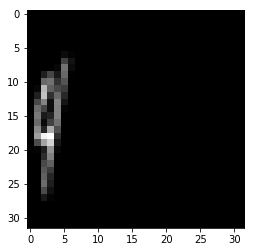

array([ 4, 10, 10, 10, 10])

In [38]:
i=84
plt.imshow(test_dataset[i],cmap='gray')
plt.show()
test_labels[i]

In [15]:
del mnist


In [25]:
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (11000, 32, 32) (11000, 5)
Validation set (1000, 32, 32) (1000, 5)
Test set (2000, 32, 32) (2000, 5)


In [43]:
image_size = 32

num_channels = 1 # grayscale

def reformat(dataset):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    return dataset
train_dataset = reformat(train_dataset)
valid_dataset = reformat(valid_dataset)
test_dataset = reformat(test_dataset)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (11000, 32, 32, 1) (11000, 5)
Validation set (1000, 32, 32, 1) (1000, 5)
Test set (2000, 32, 32, 1) (2000, 5)


In [39]:
def accuracy_single(predictions, labels):
    """calculate character-level accuracy"""
    a = np.argmax(predictions, 2).T == labels[:,0:5]
    #print(a[3])
    length = np.count_nonzero((10 > labels),axis=1).reshape(len(labels),1)
    #print('a ', a.shape,' ',length.shape,'  ',np.sum(a),' ',np.sum(length))
    #print(length[:4])
    summ = 0.0
    for i in range(len(length)):
        #print(a[i,:length[i][0]])
        summ += np.sum(a[i,:int(length[i])])       
    return(100 * summ / np.sum(length))

In [40]:
def accuracy_multi(predictions, labels):
    """calculate sequence-level accuracy"""
    count = predictions.shape[1]
    return 100.0 * (count - np.sum([1 for i in np.argmax(predictions, 2).T == labels[:,0:5]\
                                    if False in i])) / count

In [54]:
batch_size = 64
patch_size = 5 # conv kernel size
depth1 = 16
depth2 = 32
depth3 = 64 ##128
num_hidden = 64 ##128

image_size = 32
num_labels = 11 
num_channels = 1 # grayscale

graph = tf.Graph()

with graph.as_default():

    def get_weight_variable(name, shape):
        return tf.get_variable(name, shape=shape,\
                               initializer=tf.contrib.layers.xavier_initializer_conv2d())

    def bias_variable(shape):
        initial = tf.constant(1.0, shape = shape)
        return tf.Variable(initial)
    
    def conv2d(data, weight):
        # strides [1, x_movement, y_movement, 1]
        return tf.nn.conv2d(data, weight, strides = [1, 1, 1, 1], padding = 'VALID')

    def max_pooling(data):
        return tf.nn.max_pool(data, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    def get_label_wb(weight_name):
        weights = tf.get_variable(weight_name, shape=[num_hidden, num_labels],\
                                  initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        return weights, biases 
    
    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 5))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    
    
    # Varibles
    # conv1 layer 1
    layer1_weights = get_weight_variable('CNN_W1', [7, 7, num_channels, depth1])
    layer1_biases = bias_variable([depth1]) # 16
    # conv2 layer 2
    layer2_weights = get_weight_variable('CNN_W2', [patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2]) # 32
    # conv3 layer 3
    layer3_weights = get_weight_variable('CNN_W3', [5, 5, depth2, depth3])
    layer3_biases = bias_variable([depth3]) # 64
    
    # func1 layer 4
    layer4_weights = get_weight_variable('FC_W1',[64, num_hidden]) ###
    layer4_biases = bias_variable([num_hidden])
    
    # locally connected layers
    s1_w, s1_b = get_label_wb('S1_W')
    s2_w, s2_b = get_label_wb('S2_W')
    s3_w, s3_b = get_label_wb('S3_W')
    s4_w, s4_b = get_label_wb('S4_W')
    s5_w, s5_b = get_label_wb('S5_W')
    
    sw = [s1_w, s2_w, s3_w, s4_w, s5_w]
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    
    def model(dataset, keep_prob, keep_prob2):
        # conv1 layer 1
        hidden1 = tf.nn.relu(conv2d(dataset, layer1_weights) + layer1_biases) # 32 * 32 * depth1
        #hidden1 = tf.nn.local_response_normalization(hidden1)
        pool1 = max_pooling(hidden1) # 16 * 16 * depth1
        
        # conv2 layer 2
        hidden2 = tf.nn.relu(conv2d(pool1, layer2_weights) + layer2_biases) # 16 * 16 * depth2
        #hidden2 = tf.nn.local_response_normalization(hidden2)
        pool2 = max_pooling(hidden2) # 8 * 8 * depth2
        
        pool2 = tf.nn.dropout(pool2, keep_prob2)
        
        # conv3 layer 3
        hidden3 = tf.nn.relu(conv2d(pool2, layer3_weights) + layer3_biases) # 8 * 8 * depth3
        #hidden3 = tf.nn.local_response_normalization(hidden3)
        pool3 = max_pooling(hidden3) # 4 * 4 * depth3
        
        pool3 = tf.nn.dropout(pool3, keep_prob2)
        
        shape = pool3.get_shape().as_list()
        pool3_flat = tf.reshape(pool3, [shape[0], shape[1] * shape[2] * shape[3]]) # 1024
#         print(shape[0], shape[1] * shape[2] * shape[3])
        
        # func1 layer 4
        hidden4 = tf.nn.relu(tf.matmul(pool3_flat, layer4_weights) + layer4_biases)
        hidden4_drop = tf.nn.dropout(hidden4, keep_prob)

        logits_1 = tf.matmul(hidden4_drop, s1_w) + s1_b
        logits_2 = tf.matmul(hidden4_drop, s2_w) + s2_b
        logits_3 = tf.matmul(hidden4_drop, s3_w) + s3_b
        logits_4 = tf.matmul(hidden4_drop, s4_w) + s4_b
        logits_5 = tf.matmul(hidden4_drop, s5_w) + s5_b
        
        return [logits_1, logits_2, logits_3, logits_4, logits_5]
    
    # Training computation.
    logits = model(tf_train_dataset, 0.5, 0.8)
    
    loss_per_digit = [tf.reduce_mean(
                        tf.nn.sparse_softmax_cross_entropy_with_logits(
                            logits=logits[i],
                            labels=tf_train_labels[:,i]
                        )) + beta_regul * tf.nn.l2_loss(sw[i])
                       for i in range(5)]
    
    loss = tf.add_n(loss_per_digit)

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.001, global_step, 1000, 0.90, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    def prediction_softmax(dataset):
        prediction = tf.stack([
            tf.nn.softmax(model(dataset, 1.0, 1.0)[0]),
            tf.nn.softmax(model(dataset, 1.0, 1.0)[1]),
            tf.nn.softmax(model(dataset, 1.0, 1.0)[2]),
            tf.nn.softmax(model(dataset, 1.0, 1.0)[3]),
            tf.nn.softmax(model(dataset, 1.0, 1.0)[4])])
        return prediction
    
    # Predictions for the training, validation, and test data.
    train_prediction = prediction_softmax(tf_train_dataset)
    valid_prediction = prediction_softmax(tf_valid_dataset)             
    test_prediction = prediction_softmax(tf_test_dataset)
    
    # Save Model 
    #saver = tf.train.Saver()

In [ ]:
num_steps = 501

with tf.Session(graph=graph) as session:

    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-2}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            #print('Minibatch single digit accuracy: %.1f%%' % accuracy_single(predictions, batch_labels))
            #print('Minibatch image accuracy: %.1f%%' % accuracy_multi(predictions, batch_labels))
            print('Validation single digit accuracy: %.1f%%' % accuracy_single(valid_prediction.eval(), valid_labels))
            print('Validation image accuracy: %.1f%%' % accuracy_multi(valid_prediction.eval(), valid_labels))
            
    print('Test single digit accuracy: %.1f%%' % accuracy_single(test_prediction.eval(), test_labels))
    print('Test image accuracy: %.1f%%' % accuracy_multi(test_prediction.eval(), test_labels))
    
        
    #save_path = saver.save(session, "cnn_64_1.ckpt")
    #print('Model saved in file: {}'.format(save_path))

## SVHN 

In [147]:
pickle_file = 'SVHN_multi_crop_32_box.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    train_labelsbox = save['train_labelsbox']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    valid_labelsbox = save['valid_labelsbox']    
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    test_labelsbox = save['test_labelsbox']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape,train_labelsbox.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape,valid_labelsbox.shape)
    print('Test set', test_dataset.shape, test_labels.shape,test_labelsbox.shape)

Training set (27401, 32, 32) (27401, 6) (27401, 20)
Validation set (6000, 32, 32) (6000, 6) (6000, 20)
Test set (13068, 32, 32) (13068, 6) (13068, 20)


In [148]:
# Restrict to 4000 due to memory constraints 
valid_dataset = valid_dataset[:4000]
valid_labels = valid_labels[:4000]
valid_labelsbox = valid_labelsbox[:4000]

print('Validation set', valid_dataset.shape, valid_labels.shape,valid_labelsbox.shape)

Validation set (4000, 32, 32) (4000, 6) (4000, 20)


In [149]:
image_size = 32

num_channels = 1 # grayscale

def reformat(dataset):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    return dataset
train_dataset = reformat(train_dataset)
valid_dataset = reformat(valid_dataset)
test_dataset = reformat(test_dataset)
print('Training set', train_dataset.shape, train_labels.shape,train_labelsbox.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape,valid_labelsbox.shape)

print('Test set', test_dataset.shape, test_labels.shape,test_labelsbox.shape)

Training set (27401, 32, 32, 1) (27401, 6) (27401, 20)
Validation set (4000, 32, 32, 1) (4000, 6) (4000, 20)
Test set (13068, 32, 32, 1) (13068, 6) (13068, 20)


In [193]:
#Import Data from pictures(Phone Camera)  will be tested at last to check model  for newly taken pictures also 

no_images = 8 ##Taken from phone camera 
test_dataset_local=np.ndarray(shape=(no_images, 32, 32), dtype='float32') 

def normalization(img):
        #im = rgb2gray(img) # RGB to greyscale
        mean = np.mean(img, dtype='float32')
        std = np.std(img, dtype='float32', ddof=1)
        return (img - mean) / std  

def  import_image(): 
     for i in range(no_images):
      im = Image.open("E:\\Backup\\Sample_images\\"+str(i+1)+".png").convert('L')
      size = (32, 32)
      region = im.resize(size)
      region = normalization(region)
      test_dataset_local[i,:,:] = region[:,:]
    
import_image()
test_dataset_local = reformat(test_dataset_local)
#Import labels as well
test_labels_local = genfromtxt('E:\\Backup\\Sample_images\\test_labels.csv', delimiter=',',dtype=np.int32)
print('Local test data ',test_dataset_local.shape,test_labels_local.shape)


Local test data  (8, 32, 32, 1) (8, 6)


In [207]:
import matplotlib
import matplotlib.gridspec as gridspec
def disp_sample_dataset(dataset, label,labelsbox,rand='Y',disp_line='Y'):
    if rand=='Y' :
     items = random.sample(range(dataset.shape[0]), 8)   
    else:
     items=[i for i in range(8)]
    
    plt.figure(figsize = (6,6)) # set the figure size to be square
    gs = gridspec.GridSpec(2, 4)
    # set the space between subplots and the position of the subplots in the figure
    gs.update(wspace=0.5, hspace=0.1, left = 0.1, right = 1, bottom = 0.1, top = 0.5)     
    i=0
    for g in gs:
        ax = plt.subplot(g)
        plt.axis('off')
        j=items[i]
        if rand=='Y':
            plt.title(label[j][1:6])
        else :
            plt.title(label[j][1:-1])        
        if disp_line=='Y':
         for l in range((label[j][0])):
            k=l*4
            bbox = matplotlib.patches.Rectangle((labelsbox[j][k], labelsbox[j][k+1]),\
                                     labelsbox[j][k+2],labelsbox[j][k+3],fill=False)    
            #print(train_labelsbox_samp[i])
            ax.add_patch(bbox)
        plt.imshow(dataset[j,:,:,0])
        i=i+1    

plt.show()

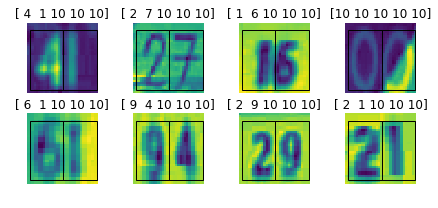

In [208]:
disp_sample_dataset(test_dataset, test_labels,test_labelsbox)

In [154]:
def labelsbox_norm(Valid_Flag,train_labelsbox,valid_labelsbox,test_labelsbox): 
    if  Valid_Flag=='LOC' : #Localize 
        train_labelsbox_norm=train_labelsbox
        valid_labelsbox_norm=valid_labelsbox
        test_labelsbox_norm=test_labelsbox       
    else:   #Other Options     
        train_labelsbox_norm=(train_labelsbox-train_labelsbox.min()) \
        /(train_labelsbox.max()-train_labelsbox.min()+1e-5)
        valid_labelsbox_norm=(valid_labelsbox-valid_labelsbox.min()) \
        /(valid_labelsbox.max()-valid_labelsbox.min()+1e-5)
        test_labelsbox_norm=(test_labelsbox-test_labelsbox.min()) \
        /(test_labelsbox.max()-test_labelsbox.min()+1e-5)
    return train_labelsbox_norm,valid_labelsbox_norm,test_labelsbox_norm

In [155]:
def accuracy_single(predictions, labels):
    """calculate character-level accuracy"""    
    a = np.argmax(predictions, 2).T == labels[:,1:6]
    length = labels[:,0]
    summ = 0.0
    for i in range(len(length)):
        summ += np.sum(a[i,:length[i]])
    #     print(a[i,:length[i]])
    return(100 * summ / np.sum(length))

In [156]:
def accuracy_multi(predictions, labels):
    """calculate sequence-level accuracy"""
    #print(predictions.shape)
    count = predictions.shape[1]
    #print(predictions[0].tolist()
    return 100.0 * (count - np.sum([1 for i in np.argmax(predictions, 2).T == labels[:,1:6]\
                                    if False in i])) / count

In [182]:
import pandas as pd
def acc_batch_iou(pred, labels, epsilon=1e-5):
    start=-4
    sum_iou=0
    list_data=[]
    
    #print(pred.shape)
    #pd_pred = pd.DataFrame(pred)
    #pd_labels = pd.DataFrame(labels)
    #pd_pred.to_csv("E:\\Backup\\pred.csv",mode="a")
    #pd_labels.to_csv("E:\\Backup\\labels.csv",mode="a")  
    
    
    for i in range(5):    
         # COORDINATES OF THE INTERSECTION BOXES
        start=start+4
        x1 = np.array([pred[:, start+0], labels[:, start+0]]).max(axis=0)
        y1 = np.array([pred[:, start+1], labels[:, start+1]]).max(axis=0)
        x2 = np.array([pred[:, start+0]+ pred[:, start+2], labels[:, start+0]+ labels[:, start+2]]).min(axis=0) ##Add width to get X2
        y2 = np.array([pred[:, start+1]+ pred[:, start+3], labels[:, start+1]+labels[:, start+3]]).min(axis=0) ##Add height to get X2

        # AREAS OF OVERLAP - Area where the boxes intersect
        width = (x2 - x1)
        height = (y2 - y1)

        # handle case where there is NO overlap
        width[width < 0] = 0
        height[height < 0] = 0

        area_overlap = width * height

        # COMBINED AREAS
        area_a = (pred[:, start+2]) * (pred[:, start+3])
        area_b = (labels[:, start+2]) * (labels[:, start+3])
        area_combined = area_a + area_b - area_overlap

        # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
        iou = area_overlap / (area_combined + epsilon)
        list_data.append(round((np.sum(iou)/(sum(labels[:, start+2]>0)+epsilon)),2)) #Taking into consideration number of digits in image
        
    return list_data

In [196]:
batch_size = 128
patch_size = 5 # conv kernel size
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden = 64

image_size = 32
num_labels = 11 
num_boxes=20 
num_channels = 1 # grayscale

graph = tf.Graph()

option_run='LAB' # Train Labels Only 

#Normalize Box Coordinates 
train_labelsbox_norm,valid_labelsbox_norm,test_labelsbox_norm=\
labelsbox_norm(option_run,train_labelsbox,valid_labelsbox,test_labelsbox)


with graph.as_default():

    def get_weight_variable(name, shape):
        return tf.get_variable(name, shape=shape,\
                               initializer=tf.contrib.layers.xavier_initializer_conv2d())

    def bias_variable(shape):
        initial = tf.constant(1.0, shape = shape)
        return tf.Variable(initial)
    
    def conv2d(data, weight):
        # strides [1, x_movement, y_movement, 1]
        return tf.nn.conv2d(data, weight, strides = [1, 1, 1, 1], padding = 'VALID')

    def max_pooling(data):
        return tf.nn.max_pool(data, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    def get_label_wb(weight_name):
        weights = tf.get_variable(weight_name, shape=[num_hidden, num_labels],\
                                  initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        return weights, biases 
    
    #Label box Weights  
    def get_labelbox_wb(weight_name):
        weights = tf.get_variable(weight_name, shape=[num_hidden, num_boxes],\
                                  initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.Variable(tf.constant(1.0, shape=[num_boxes]))
        return weights, biases 
    
    
    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_train_labelsbox_norm = tf.placeholder(tf.float32, shape=(batch_size, 20))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_test_dataset_local = tf.constant(test_dataset_local)    
    beta_regul = tf.placeholder(tf.float32)
    run_option=tf.placeholder(tf.string) #LAB - Get valid labels,LOC-Localization details,BOT-Both Options
    
    
    # Varibles
    # conv1 layer 1
    layer1_weights = get_weight_variable('CNN_W1', [7, 7, num_channels, depth1])
    layer1_biases = bias_variable([depth1]) # 16
    # conv2 layer 2
    layer2_weights = get_weight_variable('CNN_W2', [patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2]) # 32
    # conv3 layer 3
    layer3_weights = get_weight_variable('CNN_W3', [5, 5, depth2, depth3])
    layer3_biases = bias_variable([depth3]) # 64
    
    # func1 layer 4
    layer4_weights = get_weight_variable('FC_W1',[64, num_hidden]) ##Not image size 
    layer4_biases = bias_variable([num_hidden])
    
    # locally connected layers
    s1_w, s1_b = get_label_wb('S1_W')
    s2_w, s2_b = get_label_wb('S2_W')
    s3_w, s3_b = get_label_wb('S3_W')
    s4_w, s4_b = get_label_wb('S4_W')
    s5_w, s5_b = get_label_wb('S5_W')
    
     # locally connected layers for boxes
    sb1_w, sb1_b = get_labelbox_wb('SB1_W')
    
    
    sw = [s1_w, s2_w, s3_w, s4_w, s5_w]
    sbw = [sb1_w]
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    
    def model(dataset, keep_prob, keep_prob2):
        # conv1 layer 1
        #print(' 11 ',dataset.shape,' l1w ',layer1_weights.get_shape().as_list(),' l1b ',              layer1_biases.get_shape().as_list())
        hidden1 = tf.nn.relu(conv2d(dataset, layer1_weights) + layer1_biases) # 32 * 32 * depth1
        hidden1 = tf.nn.local_response_normalization(hidden1)
        pool1 = max_pooling(hidden1) # 16 * 16 * depth1
        
        #print(' 22 ',' h1 ',hidden1.get_shape().as_list(),' p1  ',pool1.get_shape().as_list())
        
        # conv2 layer 2
        hidden2 = tf.nn.relu(conv2d(pool1, layer2_weights) + layer2_biases) # 16 * 16 * depth2
        hidden2 = tf.nn.local_response_normalization(hidden2)
        pool2 = max_pooling(hidden2) # 8 * 8 * depth2
    
        #print(' 33 ',' h2 ',hidden2.get_shape().as_list(),' p1  ',pool2.get_shape().as_list())
    
        pool2 = tf.nn.dropout(pool2, keep_prob2)
        
        # conv3 layer 3
        hidden3 = tf.nn.relu(conv2d(pool2, layer3_weights) + layer3_biases) # 8 * 8 * depth3
        hidden3 = tf.nn.local_response_normalization(hidden3)
        pool3 = max_pooling(hidden3) # 4 * 4 * depth3
        
        #print(' 44 ',' h3 ',hidden2.get_shape().as_list(),' p3  ',pool3.get_shape().as_list())
        
        pool3 = tf.nn.dropout(pool3, keep_prob2)
        
        shape = pool3.get_shape().as_list()
        pool3_flat = tf.reshape(pool3, [shape[0], shape[1] * shape[2] * shape[3]]) # 1024
#         print(shape[0], shape[1] * shape[2] * shape[3])
        
        # func1 layer 4
        
        #print(' 55 ',' h3 ',pool3_flat.get_shape().as_list(),' l4w  ',layer4_weights.get_shape().as_list())
        
        hidden4 = tf.nn.relu(tf.matmul(pool3_flat, layer4_weights) + layer4_biases)
        hidden4_drop = tf.nn.dropout(hidden4, keep_prob)
        
        
        
        logits_1 = tf.matmul(hidden4_drop, s1_w) + s1_b
        logits_2 = tf.matmul(hidden4_drop, s2_w) + s2_b
        logits_3 = tf.matmul(hidden4_drop, s3_w) + s3_b
        logits_4 = tf.matmul(hidden4_drop, s4_w) + s4_b
        logits_5 = tf.matmul(hidden4_drop, s5_w) + s5_b
        
        #Bounding Box Weights
        logits_box = tf.matmul(hidden4_drop, sb1_w) + sb1_b
        
                
        
        return ([logits_1, logits_2, logits_3, logits_4, logits_5], \
                [logits_box])
    
    # Training computation.
    logits,boxes = model(tf_train_dataset, 0.5, 0.8)
    
       
    loss_per_digit =tf.reduce_mean(
                        tf.nn.sparse_softmax_cross_entropy_with_logits(
                            logits=logits[0],
                            labels=tf_train_labels[:,0+1]
                        )) + beta_regul * tf.nn.l2_loss(sw[0]) +tf.reduce_mean(
                        tf.nn.sparse_softmax_cross_entropy_with_logits(
                            logits=logits[1],
                            labels=tf_train_labels[:,0+2]
                        )) + beta_regul * tf.nn.l2_loss(sw[1]) +tf.reduce_mean(
                        tf.nn.sparse_softmax_cross_entropy_with_logits(
                            logits=logits[2],
                            labels=tf_train_labels[:,0+3]
                        )) + beta_regul * tf.nn.l2_loss(sw[2]) +  tf.reduce_mean(
                        tf.nn.sparse_softmax_cross_entropy_with_logits(
                            logits=logits[3],
                            labels=tf_train_labels[:,0+4]
                        )) + beta_regul * tf.nn.l2_loss(sw[3]) + tf.reduce_mean(
                        tf.nn.sparse_softmax_cross_entropy_with_logits(
                            logits=logits[4],
                            labels=tf_train_labels[:,0+5]
                        )) + beta_regul * tf.nn.l2_loss(sw[4])     
    
    
    loss = loss_per_digit 
        
    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.001, global_step, 1000, 0.90, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    
    def prediction_softmax(dataset):
        pr=model(dataset, 1.0, 1.0)
        prediction = tf.stack([
            tf.nn.softmax(pr[0][0]),
            tf.nn.softmax(pr[0][1]),
            tf.nn.softmax(pr[0][2]),
            tf.nn.softmax(pr[0][3]),
            tf.nn.softmax(pr[0][4])])
        
        prediction_box=pr[1]
        return prediction,prediction_box
    
    # Predictions for the training, validation, and test data.
    train_prediction = prediction_softmax(tf_train_dataset)
    valid_prediction = prediction_softmax(tf_valid_dataset)             
    test_prediction = prediction_softmax(tf_test_dataset)
    test_prediction_local = prediction_softmax(tf_test_dataset_local)
    
    # Save Model 
    saver = tf.train.Saver()

## Finding Labels only

In [159]:
num_steps = 101

with tf.Session(graph=graph) as session:

    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        batch_labelsbox=train_labelsbox_norm[offset:(offset + batch_size), :]        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul :1e-3,\
                     tf_train_labelsbox_norm : batch_labelsbox,run_option :option_run }
        
        _,l,predictions = session.run(
          [optimizer,loss,train_prediction], feed_dict=feed_dict)
        if (step % 10 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch single digit accuracy: %.1f%%' % accuracy_single(predictions[0], batch_labels))            
            print('Minibatch image accuracy: %.1f%%' % accuracy_multi(predictions[0], batch_labels))
            #print('Validation single digit accuracy: %.1f%%' % accuracy_single(valid_prediction.eval(), valid_labels))
            preds=session.run(valid_prediction)            
            print('Validation image accuracy: %.1f%%' % accuracy_multi(np.array(preds[0]), valid_labels))            
            
    preds=session.run(test_prediction)
    #print('Test single digit accuracy: %.1f%%' % accuracy_single(np.array(preds[0]), test_labels))
    #print('Test image accuracy: %.1f%%' % accuracy_multi(np.array(preds[0]), test_labels))                
            
    #save_path = saver.save(session, "cnn_64_1_label.ckpt")
    #print('Model saved in file: {}'.format(save_path))


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 23.247057
Minibatch single digit accuracy: 16.0%
Minibatch image accuracy: 0.0%
Validation image accuracy: 0.0%
Minibatch loss at step 10: 14.002529
Minibatch single digit accuracy: 24.7%
Minibatch image accuracy: 0.0%
Validation image accuracy: 0.1%
Minibatch loss at step 20: 11.432989
Minibatch single digit accuracy: 22.4%
Minibatch image accuracy: 0.8%
Validation image accuracy: 0.1%
Minibatch loss at step 30: 8.904126
Minibatch single digit accuracy: 17.5%
Minibatch image accuracy: 3.9%
Validation image accuracy: 3.5%
Minibatch loss at step 40: 8.011426
Minibatch single digit accuracy: 18.1%
Minibatch image accuracy: 1.6%
Validation image accuracy: 3.5%
Minibatch loss at step 50: 7.244792
Minibatch single digit accuracy: 17.0%
Minibatch image accuracy: 2.3%
Validation image accuracy: 3.5%
Minibatch loss at step 60: 6.978683
Minibatch single digit accuracy: 17.3%
Minibatch

## Test Local Pictures

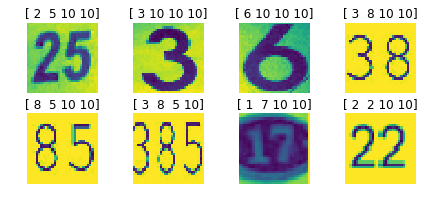

In [194]:
disp_sample_dataset(test_dataset_local, test_labels_local,test_labelsbox,'N','N')

In [197]:
with tf.Session(graph=graph) as session:
    
    # If you want to restore model
    saver.restore(session, "E:\\Backup\\Model\\cnn_64_1_label.ckpt")
    print("Model restored!")

    preds=session.run(test_prediction_local)    
    print('Test single digit accuracy: %.1f%%' % accuracy_single(np.array(preds[0]), test_labels_local))

    print('Test image accuracy: %.1f%%' % accuracy_multi(np.array(preds[0]), test_labels_local))       

Model restored!
Test single digit accuracy: 86.7%
Test image accuracy: 75.0%


In [198]:
#Process Predicted Label
st_pred=np.hstack([preds[0][0].tolist(),preds[0][1].tolist(),preds[0][2].tolist(),\
                  preds[0][3].tolist(),preds[0][4].tolist()])
pred_labels=np.hstack([np.argmax(st_pred[:,0:11],axis=1).reshape(no_images,1),np.argmax(st_pred[:,11:22],axis=1).reshape(no_images,1),\
           np.argmax(st_pred[:,22:33],axis=1).reshape(no_images,1),np.argmax(st_pred[:,33:44],axis=1).reshape(no_images,1)\
           ,np.argmax(st_pred[:,44:55],axis=1).reshape(no_images,1)])

In [199]:
get_labels = lambda a,i,j : (''.join(map(str, a[i:i+1,0:j])))
pred_labels_disp=[]
for i in range(8):
    pred_labels_disp.append(((get_labels(pred_labels,i,int(np.sum(pred_labels[i:i+1,:]<10,axis=1))))))

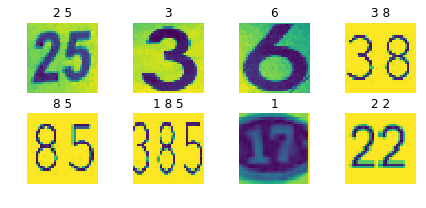

In [200]:
disp_sample_dataset(test_dataset_local, pred_labels_disp,test_labelsbox,rand='N',disp_line='N')

## Localization 

In [201]:
batch_size = 128
patch_size = 5 # conv kernel size
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden = 64

image_size = 32
num_labels = 11 
num_boxes=20 
num_channels = 1 # grayscale

graph = tf.Graph()

#Normalize Box Coordinates 
train_labelsbox_norm,valid_labelsbox_norm,test_labelsbox_norm=\
labelsbox_norm('LOC',train_labelsbox,valid_labelsbox,test_labelsbox)


with graph.as_default():

    def get_weight_variable(name, shape):
        return tf.get_variable(name, shape=shape,\
                               initializer=tf.contrib.layers.xavier_initializer_conv2d())

    def bias_variable(shape):
        initial = tf.constant(1.0, shape = shape)
        return tf.Variable(initial)
    
    def conv2d(data, weight):
        # strides [1, x_movement, y_movement, 1]
        return tf.nn.conv2d(data, weight, strides = [1, 1, 1, 1], padding = 'VALID')

    def max_pooling(data):
        return tf.nn.max_pool(data, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    def get_label_wb(weight_name):
        weights = tf.get_variable(weight_name, shape=[num_hidden, num_labels],\
                                  initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        return weights, biases 
    
    #Label box Weights  
    def get_labelbox_wb(weight_name):
        weights = tf.get_variable(weight_name, shape=[num_hidden, num_boxes],\
                                  initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.Variable(tf.constant(1.0, shape=[num_boxes]))
        return weights, biases 
    
    
    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_train_labelsbox_norm = tf.placeholder(tf.float32, shape=(batch_size, 20))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_test_dataset_local = tf.constant(test_dataset_local)
    beta_regul = tf.placeholder(tf.float32)
    
    
    # Varibles
    # conv1 layer 1
    layer1_weights = get_weight_variable('CNN_W1', [7, 7, num_channels, depth1])
    layer1_biases = bias_variable([depth1]) # 16
    # conv2 layer 2
    layer2_weights = get_weight_variable('CNN_W2', [patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2]) # 32
    # conv3 layer 3
    layer3_weights = get_weight_variable('CNN_W3', [5, 5, depth2, depth3])
    layer3_biases = bias_variable([depth3]) # 64
    
    # func1 layer 4
    layer4_weights = get_weight_variable('FC_W1',[64, num_hidden]) ##Not image size 
    layer4_biases = bias_variable([num_hidden])
    
    # locally connected layers
    s1_w, s1_b = get_label_wb('S1_W')
    s2_w, s2_b = get_label_wb('S2_W')
    s3_w, s3_b = get_label_wb('S3_W')
    s4_w, s4_b = get_label_wb('S4_W')
    s5_w, s5_b = get_label_wb('S5_W')
    
     # locally connected layers for boxes
    sb1_w, sb1_b = get_labelbox_wb('SB1_W')
    
    
    sw = [s1_w, s2_w, s3_w, s4_w, s5_w]
    sbw = [sb1_w]
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    
    def model(dataset, keep_prob, keep_prob2):
        # conv1 layer 1
        #print(' 11 ',dataset.shape,' l1w ',layer1_weights.get_shape().as_list(),' l1b ',              layer1_biases.get_shape().as_list())
        hidden1 = tf.nn.relu(conv2d(dataset, layer1_weights) + layer1_biases) # 32 * 32 * depth1
        hidden1 = tf.nn.local_response_normalization(hidden1)
        pool1 = max_pooling(hidden1) # 16 * 16 * depth1
        
        #print(' 22 ',' h1 ',hidden1.get_shape().as_list(),' p1  ',pool1.get_shape().as_list())
        
        # conv2 layer 2
        hidden2 = tf.nn.relu(conv2d(pool1, layer2_weights) + layer2_biases) # 16 * 16 * depth2
        hidden2 = tf.nn.local_response_normalization(hidden2)
        pool2 = max_pooling(hidden2) # 8 * 8 * depth2
    
        #print(' 33 ',' h2 ',hidden2.get_shape().as_list(),' p1  ',pool2.get_shape().as_list())
    
        pool2 = tf.nn.dropout(pool2, keep_prob2)
        
        # conv3 layer 3
        hidden3 = tf.nn.relu(conv2d(pool2, layer3_weights) + layer3_biases) # 8 * 8 * depth3
        hidden3 = tf.nn.local_response_normalization(hidden3)
        pool3 = max_pooling(hidden3) # 4 * 4 * depth3
        
        #print(' 44 ',' h3 ',hidden2.get_shape().as_list(),' p3  ',pool3.get_shape().as_list())
        
        pool3 = tf.nn.dropout(pool3, keep_prob2)
        
        shape = pool3.get_shape().as_list()
        pool3_flat = tf.reshape(pool3, [shape[0], shape[1] * shape[2] * shape[3]]) # 1024
#         print(shape[0], shape[1] * shape[2] * shape[3])
        
        # func1 layer 4
        
        #print(' 55 ',' h3 ',pool3_flat.get_shape().as_list(),' l4w  ',layer4_weights.get_shape().as_list())
        
        hidden4 = tf.nn.relu(tf.matmul(pool3_flat, layer4_weights) + layer4_biases)
        hidden4_drop = tf.nn.dropout(hidden4, keep_prob)
        
        
        
        logits_1 = tf.matmul(hidden4_drop, s1_w) + s1_b
        logits_2 = tf.matmul(hidden4_drop, s2_w) + s2_b
        logits_3 = tf.matmul(hidden4_drop, s3_w) + s3_b
        logits_4 = tf.matmul(hidden4_drop, s4_w) + s4_b
        logits_5 = tf.matmul(hidden4_drop, s5_w) + s5_b
        
        #Bounding Box Weights
        logits_box = tf.matmul(hidden4_drop, sb1_w) + sb1_b
        
                
        
        return ([logits_1, logits_2, logits_3, logits_4, logits_5], \
                [logits_box])
    
    # Training computation.
    logits,boxes = model(tf_train_dataset, 0.5, 0.8)
    
       
    loss_per_digit_box =tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(boxes[0][:,0:4], \
                            tf_train_labelsbox_norm[:,0:4]))))) \
                        + tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(boxes[0][:,4:8],\
                            tf_train_labelsbox_norm[:,4:8])))))  \
                        + tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(boxes[0][:,8:12],\
                            tf_train_labelsbox_norm[:,8:12]))))) \
                        + tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(boxes[0][:,12:16],\
                            tf_train_labelsbox_norm[:,12:16]))))) \
                        + tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(boxes[0][:,16:20],\
                            tf_train_labelsbox_norm[:,16:20]))))) 
     
      
    
    
    #print(' 166 ',np.array(loss_per_digit_box).dtype)
    
    loss = loss_per_digit_box  # +   loss_per_digit_box 
    
    #loss = loss_per_digit + loss_per_digit_box  # +   loss_per_digit_box 
    
    #loss_box = tf.add_n(loss_per_digit_box)
    
    #print(' 177 ',' loss ',loss.get_shape().as_list(),'loss b',loss_box.get_shape().as_list())
    #tot_loss=tf.add_n(loss,loss_box)

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.001, global_step, 1000, 0.90, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #optimizer_b = tf.train.AdamOptimizer(learning_rate).minimize(loss_box, global_step=global_step)
    
    def prediction_softmax(dataset):
        pr=model(dataset, 1.0, 1.0)
        prediction = tf.stack([
            tf.nn.softmax(pr[0][0]),
            tf.nn.softmax(pr[0][1]),
            tf.nn.softmax(pr[0][2]),
            tf.nn.softmax(pr[0][3]),
            tf.nn.softmax(pr[0][4])])
        
        prediction_box=pr[1]
        return prediction,prediction_box
    
    # Predictions for the training, validation, and test data.
    train_prediction = prediction_softmax(tf_train_dataset)
    valid_prediction = prediction_softmax(tf_valid_dataset)             
    test_prediction = prediction_softmax(tf_test_dataset)
    test_prediction_local = prediction_softmax(tf_test_dataset_local)
    
    # Save Model 
    saver = tf.train.Saver()

In [189]:
num_steps = 101

with tf.Session(graph=graph) as session:

    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        batch_labelsbox=train_labelsbox_norm[offset:(offset + batch_size), :]        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul :1e-3,\
                     tf_train_labelsbox_norm : batch_labelsbox }
        
        _,l,predictions = session.run(
          [optimizer,loss,train_prediction], feed_dict=feed_dict)
        if (step % 20 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch box accuracy: ',acc_batch_iou(np.array(predictions[1])[0], batch_labelsbox))
            preds=session.run(valid_prediction)            
            print('Validation box accuracy: ',acc_batch_iou(np.array(preds[1])[0], valid_labelsbox_norm))                       
   

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 47.414268
Minibatch box accuracy:  [0.0, 0.0, 0.0, 0.0, 0.0]
Validation box accuracy:  [0.0, 0.0, 0.0, 0.0, 0.0]
Minibatch loss at step 20: 41.107357
Minibatch box accuracy:  [0.029999999999999999, 0.0, 0.0, 0.0, 0.0]
Validation box accuracy:  [0.029999999999999999, 0.0, 0.0, 0.0, 0.0]
Minibatch loss at step 40: 37.853325
Minibatch box accuracy:  [0.11, 0.0, 0.0, 0.0, 0.0]
Validation box accuracy:  [0.12, 0.0, 0.0, 0.0, 0.0]
Minibatch loss at step 60: 32.445251
Minibatch box accuracy:  [0.25, 0.02, 0.0, 0.0, 0.0]
Validation box accuracy:  [0.27000000000000002, 0.029999999999999999, 0.0, 0.0, 0.0]
Minibatch loss at step 80: 29.569258
Minibatch box accuracy:  [0.41999999999999998, 0.12, 0.0, 0.0, 0.0]
Validation box accuracy:  [0.42999999999999999, 0.14000000000000001, 0.0, 0.0, 0.0]
Minibatch loss at step 100: 27.027166
Minibatch box accuracy:  [0.56999999999999995, 0.26000000

In [202]:
#Run the session for localization 
with tf.Session(graph=graph) as session:
    
    # If you want to restore model
    saver.restore(session, "E:\\Backup\\Model\\cnn_64_1_box.ckpt")
    print("Model restored!")
    preds=session.run(test_prediction_local)        
    print("Prediction done successfully")

Model restored!
Prediction done successfully


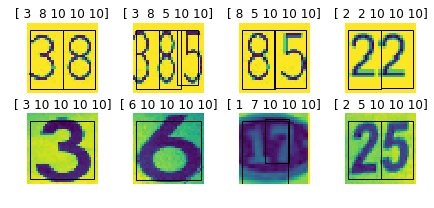

In [209]:
disp_sample_dataset(test_dataset_local, test_labels_local,preds[1][0],rand='Y',disp_line='Y')